# Análise OD-2023 - Município VS RMSP 
A [análise OD-2023](../od_23-analysis.ipynb) foi refeita comparando as viagens municipais(cidade de São Paulo) e metropolitanas(RMSP)

## Overview
As seguintes análises foram feitas:
- **Caracterização do Perfil do Pedestre - perfil demográfico**
  - Análise comparativa dos meios de transporte da OD 23 (quais os meios mais/menos utilizados)
  - Distribuição por sexo
  - Distribuição por idade
  - Distribuição por grau de instrução
  - Distribuição por condição de atividade
  - Distribuição por renda individual
  - Relação entre renda individual e grau de instrução
- **Análise Específica do Comportamento como Pedestre**
  - Razões para caminhar
  - Motivos de viagem (destino)
- **Padrões de deslocamento**
  - Distribuição de distâncias percorridas
  - Relação entre distância e motivo da viagem (destino)

In [787]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [788]:
data_path = "../../data/OD/OD-2023/od23_all.csv"
df = pd.read_csv(data_path)

**Mapeamentos da coluna meio de transporte principal**

In [789]:
meios_transporte = {
    1: "Metrô",
    2:"Trem",
    3: "Monotrilho",
    4: "O/MO/V do município de São Paulo",
    5: "O/MO/V de outros municípios",
    6: "O/MO/V metropolitano",
    7: "Transporte Fretado",
    8: "Transporte Escolar",
    9: "Dirigindo Automóvel",
    10: "Passageiro de Automóvel",
    11: "Táxi Convencional",
    12: "Táxi não Convencional / aplicativo",
    13: "Dirigindo Moto",
    14: "Passageiro de Moto",
    15: "Passageiro de Mototáxi",
    16: "Bicicleta",
    17: "A Pé",
    18: "Outros"
}

In [790]:
df['MODOPRIN_CATEG'] = df['MODOPRIN'].map(meios_transporte).fillna('Desconhecido')

Declarações para o município de São Paulo e RMSP

Código do município de São Paulo: 36

In [791]:
def query_city_sp(df):
    df = df.query('MUNI_O == 36 and MUNI_D == 36')
    return df

def query_rmsp(df):
    df = df.query('MUNI_O != 36 and MUNI_D != 36')
    # df = df.query('(MUNI_O == 36 and MUNI_D != 36) or (MUNI_O != 36 and MUNI_D == 36)')
    return df

## Comparação dos meios de transporte (OD-2023)

In [792]:
comp_transp_mode = df.groupby(['MODOPRIN_CATEG', 'MUNI_O', 'MUNI_D'])['FE_VIA'].sum().reset_index().sort_values(by='FE_VIA')
comp_transp_mode['FE_VIA_PERC'] = (comp_transp_mode['FE_VIA'] / comp_transp_mode['FE_VIA'].sum()) * 100
comp_transp_mode

,MODOPRIN_CATEG,MUNI_O,MUNI_D,FE_VIA,FE_VIA_PERC
2251,Táxi Convencional,2,24,6.832116e+00,0.000019
2262,Táxi Convencional,24,2,6.832116e+00,0.000019
1572,Passageiro de Automóvel,31,24,1.550848e+01,0.000043
2181,Trem,32,8,1.703637e+01,0.000048
2067,Trem,8,32,1.703637e+01,0.000048
...,...,...,...,...,...
1626,Passageiro de Automóvel,36,36,1.332565e+06,3.736750
910,Metrô,36,36,2.048829e+06,5.745283
560,Dirigindo Automóvel,36,36,3.696420e+06,10.365423
1048,O/MO/V do município de São Paulo,36,36,3.856526e+06,10.814388


Agrupando SP vs RMSP

In [793]:
comp_transp_mode_sp = query_city_sp(comp_transp_mode).drop(columns=['FE_VIA', 'MUNI_O', 'MUNI_D'])
comp_transp_mode_rmsp = query_rmsp(comp_transp_mode).groupby(['MODOPRIN_CATEG'])['FE_VIA_PERC'].sum().reset_index().sort_values(by='FE_VIA_PERC')

In [794]:
comparing_modes_rep_sp_rmsp = pd.concat([
    comp_transp_mode_sp.set_index('MODOPRIN_CATEG')['FE_VIA_PERC'],
    comp_transp_mode_rmsp.set_index('MODOPRIN_CATEG')['FE_VIA_PERC']
], axis=1, keys=['SP', 'RMSP']).fillna(0)

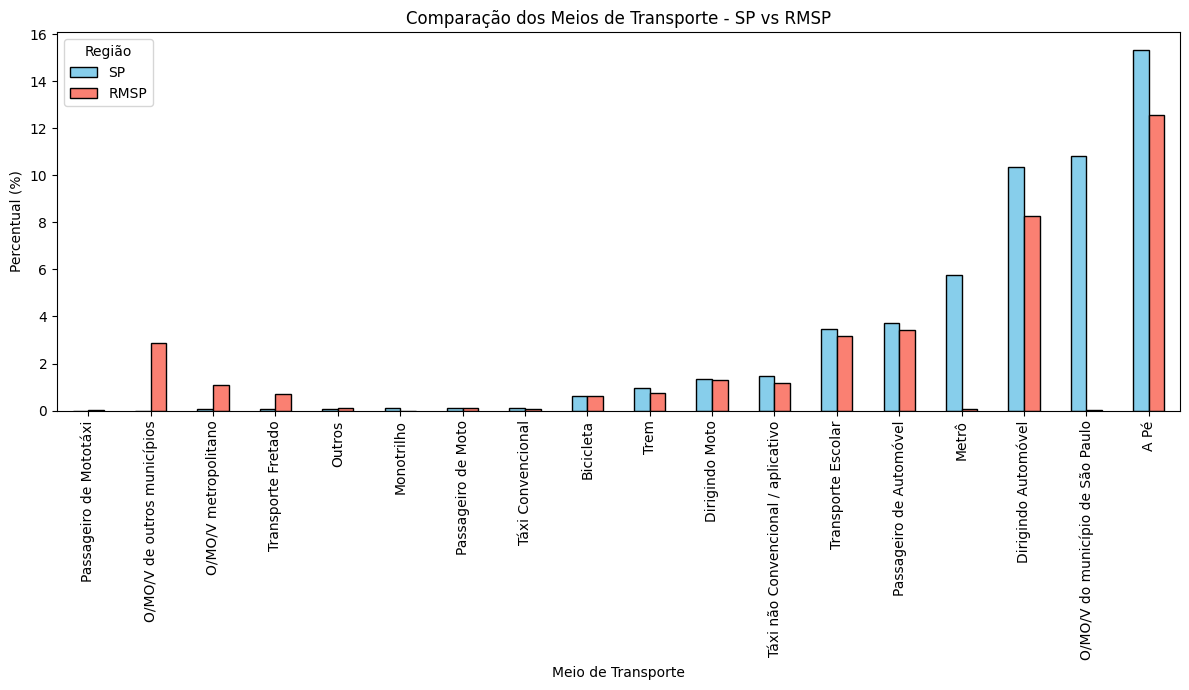

In [795]:
comparing_modes_rep_sp_rmsp.plot(kind='bar', figsize=(12, 7), color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Meio de Transporte')
plt.ylabel('Percentual (%)')
plt.title('Comparação dos Meios de Transporte - SP vs RMSP')
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**5 meios mais representativos**

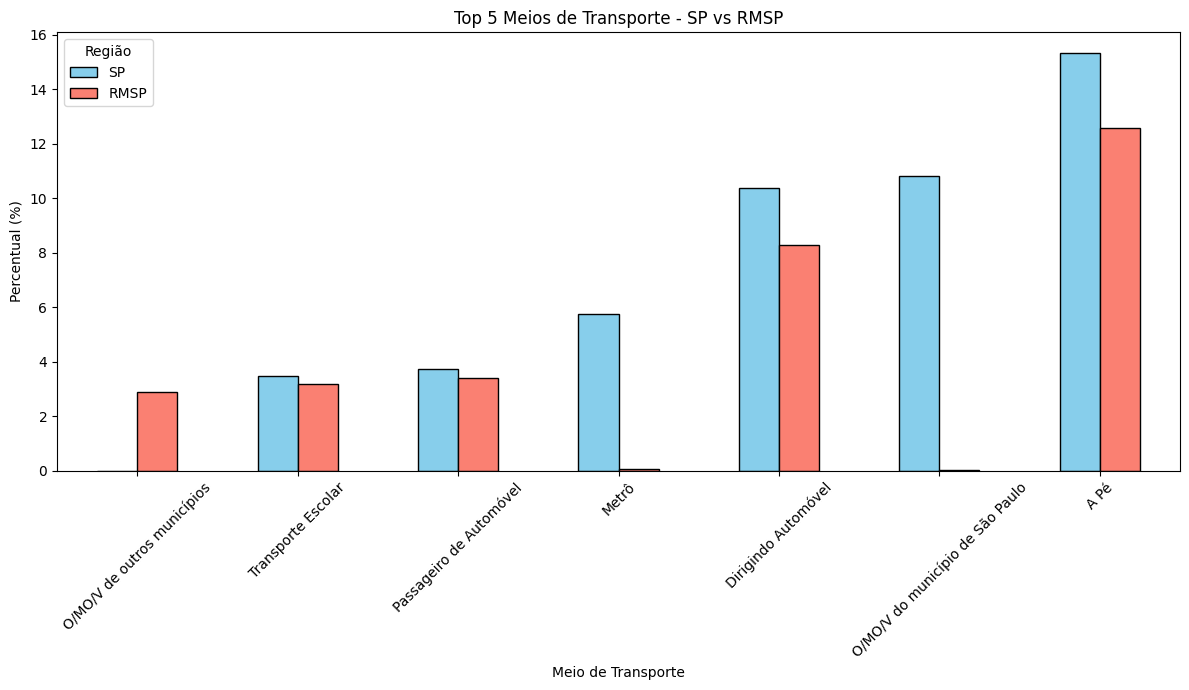

In [796]:
top_sp = comp_transp_mode_sp.nlargest(5, 'FE_VIA_PERC')['MODOPRIN_CATEG']
top_rmsp = comp_transp_mode_rmsp.nlargest(5, 'FE_VIA_PERC')['MODOPRIN_CATEG']

# União dos nomes dos modos
top_modes = pd.Index(top_sp).union(pd.Index(top_rmsp))

# Filtra ambos os DataFrames para esses modos
sp_top = comp_transp_mode_sp[comp_transp_mode_sp['MODOPRIN_CATEG'].isin(top_modes)].set_index('MODOPRIN_CATEG')
rmsp_top = comp_transp_mode_rmsp[comp_transp_mode_rmsp['MODOPRIN_CATEG'].isin(top_modes)].set_index('MODOPRIN_CATEG')

# Junta para comparação
comparing_modes_rep_sp_rmsp = pd.concat([
    sp_top['FE_VIA_PERC'],
    rmsp_top['FE_VIA_PERC']
], axis=1, keys=['SP', 'RMSP']).fillna(0)

# Plota
comparing_modes_rep_sp_rmsp.plot(kind='bar', figsize=(12, 7), color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Meio de Transporte')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45)
plt.title('Top 5 Meios de Transporte - SP vs RMSP')
plt.legend(title='Região')
plt.tight_layout()
plt.show()

## Caracterização do Perfil do Pedestre

Filtrando apenas viagens a pé

In [797]:
# Filtrando pedestres
pedestrians = df.query('MODOPRIN == 17').copy()

### Pré-processamento dos Dados
**Categorização:**
- Faixas etárias
- Distâncias percorridas
- Critério BR
- Sexo
- Raça

In [798]:
# Categorização da distância (em metros)
bins_distancia = [0, 500, 1000, 2000, 5000, float('inf')]
labels_distancia = ['Muito curta (<500m)', 'Curta (500-1000m)', 'Média (1001-2000m)', 
                   'Longa (2001-5000m)', 'Muito longa (>5000m)']

pedestrians['CAT_DISTANCIA'] = pd.cut(pedestrians['DISTANCIA'], bins=bins_distancia, labels=labels_distancia)

In [799]:
# Categorização de idade
bins_idade = [0, 12, 18, 30, 50, 65, 120]
labels_idade = ['Criança (0-12)', 'Adolescente (13-18)', 'Jovem (19-30)', 
               'Adulto (31-50)', 'Adulto 50+ (51-65)', 'Idoso (65+)']

pedestrians['CAT_IDADE'] = pd.cut(pedestrians['IDADE'], bins=bins_idade, labels=labels_idade)

In [800]:
# Mapeamento dos critérios econômicos
pedestrians['CLASSE_ECON'] = pedestrians['CRITERIOBR'].map(criterio_br)
pedestrians['CLASSE_ECON'].value_counts()

CLASSE_ECON
C2     9228
C1     8340
B2     6452
D-E    2433
B1     2243
A      1266
Name: count, dtype: int64

In [801]:
# Mapeamento do sexo
sex_labels = {1: 'Masculino', 2: 'Feminino'}
pedestrians['SEXO_LABEL'] = pedestrians['SEXO'].map(sex_labels)

In [802]:
# Mapeamento da raça
raca_labels = {1:"Branca", 2:"Preta", 3:"Amarela", 4:"Parda", 5:"Indígena", 6:"Sem declaração"}
pedestrians['RACA_LABEL'] = pedestrians['RAÇA'].map(raca_labels)

In [803]:
# Mapeamento de grau de instrução
grau_labels = {
    1: 'Fundamental I Incompleto',
    2: 'Fundamental I Comp. / Fund II Incomp.',
    3: 'Fundamental II Comp. / Médio Incomp.',
    4: 'Médio Comp. / Sup. Incompleto',
    5: 'Superior Completo'
}
pedestrians['GRAU_LABEL'] = pedestrians['GRAU_INS'].map(grau_labels)

In [804]:
# Mapeamento condição de atividade
atividade_labels = {
    1: 'Trabalho regular',
    2: 'Bico',
    3: 'Licença médica',
    4: 'Aposentado',
    5: 'Sem trabalho',
    6: 'Nunca trabalhou',
    7: 'Dona de casa',
    8: 'Estudante'
}
pedestrians['ATIVI_LABEL'] = pedestrians['CD_ATIVI'].map(atividade_labels)

In [805]:
# Mapeamento motivo escolha pelo modo a pé ou bicicleta
pe_bici_labels = {
    1:"Pequena distância", 
    2:"Condução cara", 
    3:"Ponto/Estação distante", 
    4:"Condução demora para passar", 
    5:"Viagem demorada", 
    6:"Condução lotada", 
    7:"Atividade física", 
    8:"Medo de contágio", 
    9:"Outros motivos"}
pedestrians["PE_BICI_LABEL"] = pedestrians["PE_BICI"].map(pe_bici_labels)

In [806]:
# Mapeamento motivo ao destino
motivo_labels = {
    1:"Trabalho Indústria", 
    2:"Trabalho Comércio", 
    3:"Trabalho Serviços", 
    4:"Escola/Educação", 
    5:"Compras", 6:"Médico/Dentista/Saúde", 
    7:"Recreação/Visitas/Lazer", 
    8:"Residência", 
    9:"Procurar Emprego", 
    10:"Assuntos Pessoais", 
    11:"Refeição"
}
pedestrians["MOTIVO_LABEL"] = pedestrians["MOTIVO_D"].map(motivo_labels)

Cálculo do peso de viagens de pedestres

In [807]:
pedestrians_weight = pedestrians['FE_VIA'].sum()

sp_pedestrians = query_city_sp(pedestrians)
sp_pedestrians_weight = sp_pedestrians['FE_VIA'].sum()

rmsp_pedestrians = query_rmsp(pedestrians)
rmsp_pedestrians_weight = rmsp_pedestrians['FE_VIA'].sum()

### Análise Descritiva Básica
**Perfil demográfico**
- Distribuição por sexo (SEXO)
- Distribuição por idade (IDADE)
- Distribuição por raça (RAÇA)
- Distribuição por grau de instrução (GRAU_INS)

**Características socioeconômicas**
- Distribuição por condição de atividade (CD_ATIVI)
- Distribuição de renda (VL_REN_I)
- Relação entre renda e modo pedestre

**SEXO**

In [808]:
sex_dist = (pedestrians.groupby(['SEXO_LABEL'])['FE_VIA'].sum() / pedestrians_weight * 100).round(2)

sex_dist_sp = (sp_pedestrians.groupby(['SEXO_LABEL'])['FE_VIA'].sum() / sp_pedestrians_weight * 100).round(2)

sex_dist_rmsp = (rmsp_pedestrians.groupby(['SEXO_LABEL'])['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).round(2)

display(sex_dist, sex_dist_sp, sex_dist_rmsp)

SEXO_LABEL
Feminino     56.02
Masculino    43.92
Name: FE_VIA, dtype: float64

SEXO_LABEL
Feminino     55.13
Masculino    44.85
Name: FE_VIA, dtype: float64

SEXO_LABEL
Feminino     57.2
Masculino    42.7
Name: FE_VIA, dtype: float64

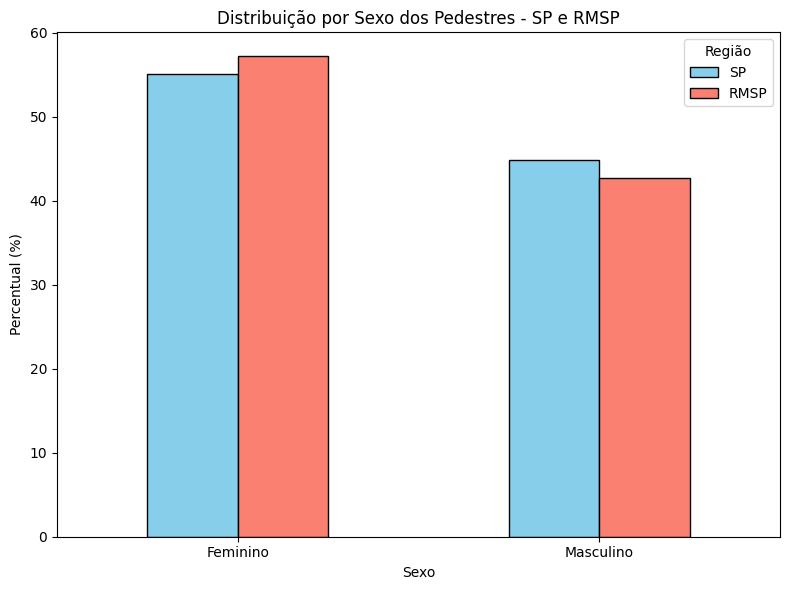

In [809]:
sex_df = pd.DataFrame({
    'SP': sex_dist_sp,
    'RMSP': sex_dist_rmsp
})

sex_df.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Distribuição por Sexo dos Pedestres - SP e RMSP')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**IDADE**

In [810]:
sp_age_stats = sp_pedestrians['IDADE'].describe().to_frame()
rmsp_age_stats = rmsp_pedestrians['IDADE'].describe().to_frame()

age_stats_comparison = pd.concat(
    [sp_age_stats.rename(columns={'IDADE': 'SP'}), rmsp_age_stats.rename(columns={'IDADE': 'RMSP'})],
    axis=1
)

age_stats_comparison = age_stats_comparison.round(2)
age_stats_comparison

,SP,RMSP
count,19858.00,9871.00
mean,33.86,29.90
std,20.20,19.46
min,1.00,1.00
25%,16.00,14.00
50%,33.00,26.00
75%,49.00,45.00
max,95.00,92.00


In [811]:
sp_age_cat_dist = ((sp_pedestrians.groupby('CAT_IDADE', observed=False)['FE_VIA'].sum() / sp_pedestrians_weight * 100).reindex(labels_idade)).round(2)
rmsp_age_cat_dist = ((rmsp_pedestrians.groupby('CAT_IDADE', observed=False)['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).reindex(labels_idade)).round(2)

age_cat_comparison = pd.DataFrame({
    'SP': sp_age_cat_dist,
    'RMSP': rmsp_age_cat_dist
})

age_cat_comparison

,SP,RMSP
CAT_IDADE,,
Criança (0-12),24.12,24.20
Adolescente (13-18),16.00,20.87
Jovem (19-30),14.86,13.86
Adulto (31-50),29.05,27.83
Adulto 50+ (51-65),11.89,10.35
Idoso (65+),4.07,2.89


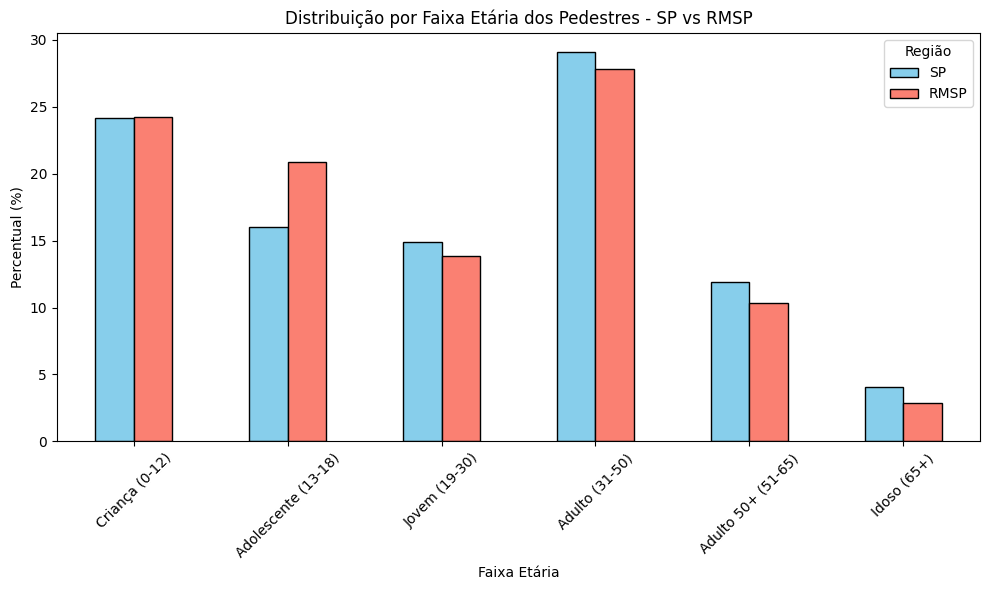

In [812]:
age_cat_comparison.plot(kind='bar', figsize=(10, 6), edgecolor='black', color=['skyblue', 'salmon'])
plt.title('Distribuição por Faixa Etária dos Pedestres - SP vs RMSP')
plt.xlabel('Faixa Etária')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**RAÇA**

In [813]:
sp_race_dist = (sp_pedestrians.groupby('RACA_LABEL')['FE_VIA'].sum() / sp_pedestrians_weight * 100).round(2)
rmsp_race_dist = (rmsp_pedestrians.groupby('RACA_LABEL')['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).round(2)

race_dist_comparison = pd.DataFrame({
    'SP': sp_race_dist,
    'RMSP': rmsp_race_dist
})

race_dist_comparison

,SP,RMSP
RACA_LABEL,,
Amarela,1.11,1.37
Branca,50.75,47.14
Indígena,0.23,0.34
Parda,36.79,41.32
Preta,10.71,9.24
Sem declaração,0.41,0.60


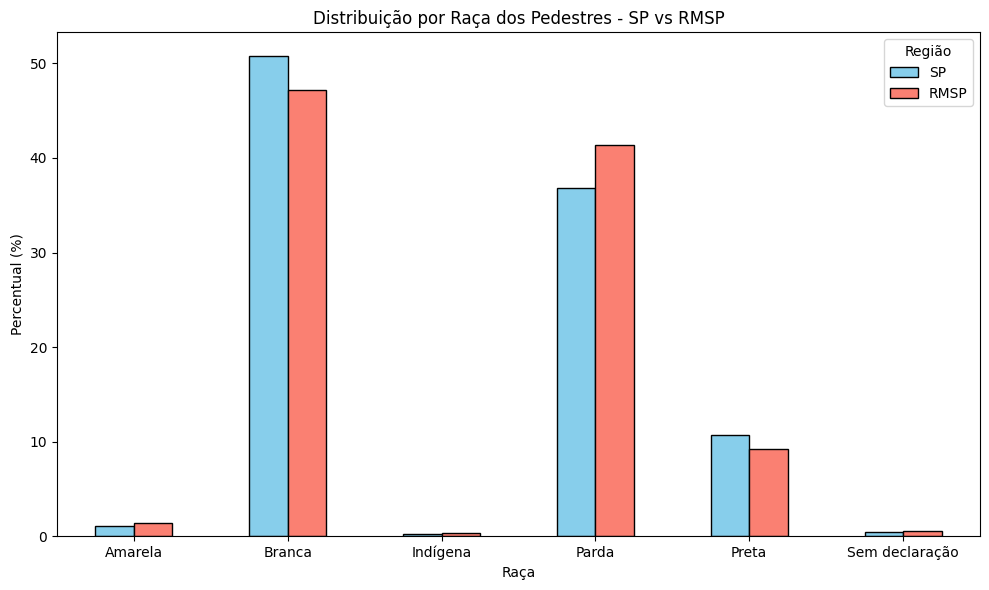

In [814]:
race_dist_comparison.plot(kind='bar', figsize=(10, 6), edgecolor='black', color=['skyblue', 'salmon'])
plt.title('Distribuição por Raça dos Pedestres - SP vs RMSP')
plt.xlabel('Raça')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=0)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**GRAU de INSTRUÇÃO**

In [815]:
sp_grau_dist = (sp_pedestrians.groupby('GRAU_LABEL')['FE_VIA'].sum() / sp_pedestrians_weight * 100).round(2).sort_values(ascending=False)
rmsp_grau_dist = (rmsp_pedestrians.groupby('GRAU_LABEL')['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).round(2).sort_values(ascending=False)

grau_dist_comparison = pd.DataFrame({
    'SP': sp_grau_dist,
    'RMSP': rmsp_grau_dist
})

grau_dist_comparison

,SP,RMSP
GRAU_LABEL,,
Fundamental I Comp. / Fund II Incomp.,17.70,20.40
Fundamental I Incompleto,21.40,22.27
Fundamental II Comp. / Médio Incomp.,17.94,18.72
Médio Comp. / Sup. Incompleto,27.84,30.36
Superior Completo,15.12,8.25


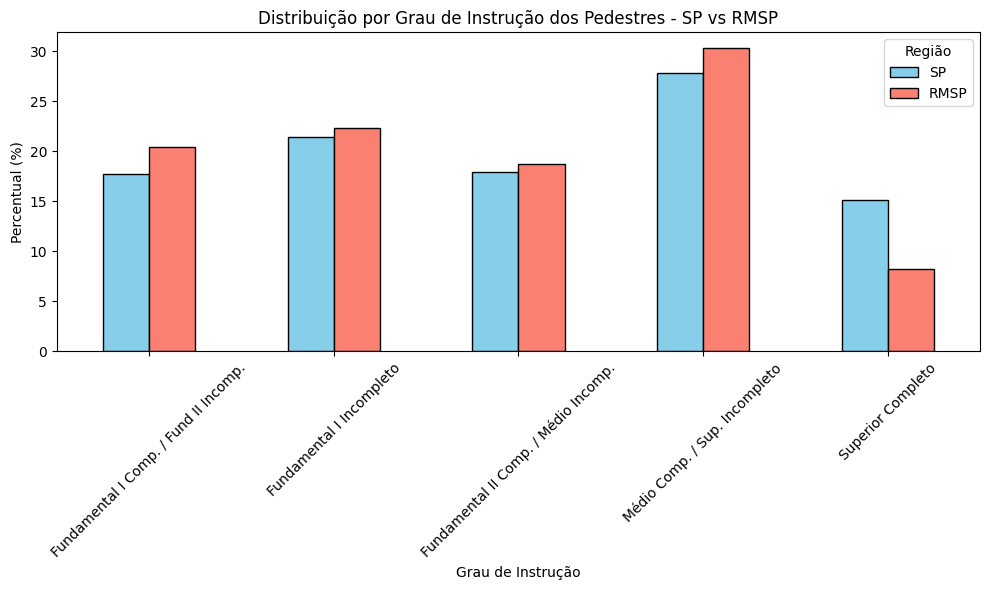

In [816]:
grau_dist_comparison.plot(kind='bar', figsize=(10, 6), edgecolor='black', color=['skyblue', 'salmon'])
plt.title('Distribuição por Grau de Instrução dos Pedestres - SP vs RMSP')
plt.xlabel('Grau de Instrução')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**CONDIÇÃO de ATIVIDADE**

In [817]:
sp_ativi_dist = (sp_pedestrians.groupby('ATIVI_LABEL')['FE_VIA'].sum() / sp_pedestrians_weight * 100).round(2)
rmsp_ativi_dist = (rmsp_pedestrians.groupby('ATIVI_LABEL')['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).round(2)


ativi_dist_comparison = pd.DataFrame({
    'SP': sp_ativi_dist,
    'RMSP': rmsp_ativi_dist
})

ativi_dist_comparison

,SP,RMSP
ATIVI_LABEL,,
Aposentado,4.78,4.01
Bico,3.41,2.83
Dona de casa,5.42,7.08
Estudante,31.01,36.59
Licença médica,0.05,0.17
Nunca trabalhou,8.23,6.41
Sem trabalho,7.29,7.55
Trabalho regular,39.82,35.37


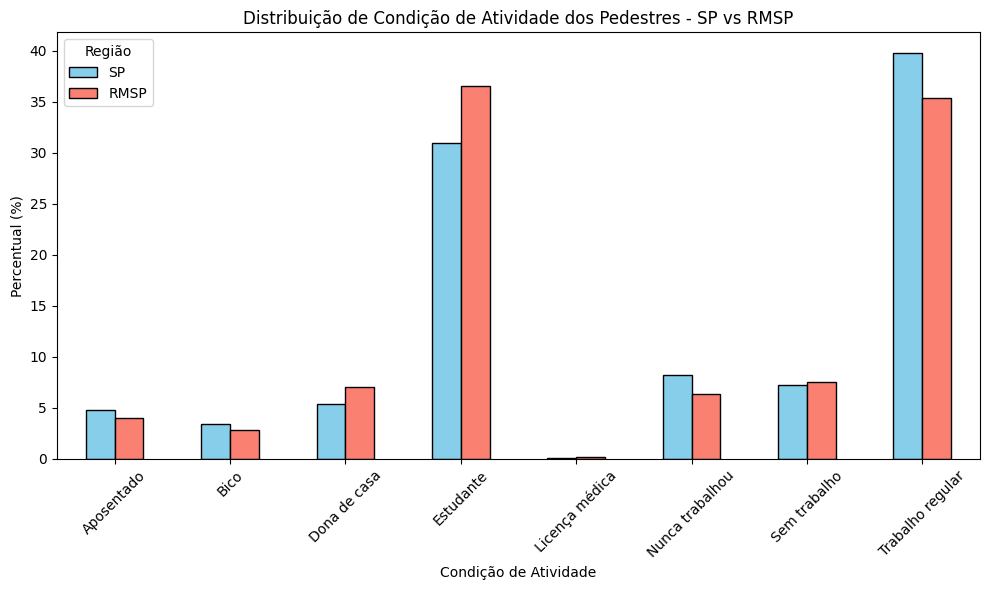

In [818]:
ativi_dist_comparison.plot(kind='bar', figsize=(10, 6), edgecolor='black', color=['skyblue', 'salmon'])
plt.title('Distribuição de Condição de Atividade dos Pedestres - SP vs RMSP')
plt.xlabel('Condição de Atividade')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**RENDA INDIVIDUAL**

In [819]:
sp_renda_stats = sp_pedestrians['VL_REN_I'].describe()
sp_p90_renda_stats = sp_pedestrians['VL_REN_I'].quantile(0.90)

rmsp_renda_stats = rmsp_pedestrians['VL_REN_I'].describe()
rmsp_p90_renda_stats = rmsp_pedestrians['VL_REN_I'].quantile(0.90)

renda_dist_comparison = pd.DataFrame({
    'SP': sp_renda_stats,
    'RMSP': rmsp_renda_stats
})

renda_dist_comparison

,SP,RMSP
count,13924.000000,7635.000000
mean,2111.859236,805.236411
std,4722.657560,1495.569551
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2200.000000,1400.000000
max,90000.000000,30000.000000


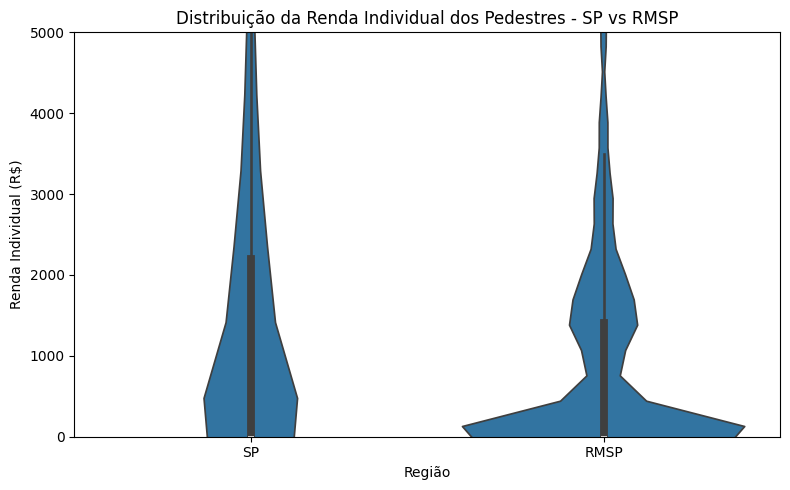

In [820]:
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=pd.concat([
        sp_pedestrians[['VL_REN_I']].assign(Regiao='SP'),
        rmsp_pedestrians[['VL_REN_I']].assign(Regiao='RMSP')
    ]),
    x='Regiao', y='VL_REN_I'
)
plt.title('Distribuição da Renda Individual dos Pedestres - SP vs RMSP')
plt.xlabel('Região')
plt.ylabel('Renda Individual (R$)')
plt.ylim(0, max(sp_p90_renda_stats, rmsp_p90_renda_stats))
plt.tight_layout()
plt.show()

**Renda Média por Grau de Instrução de Pedestres**

In [821]:
sp_renda_grau = sp_pedestrians.groupby('GRAU_LABEL')['VL_REN_I'].mean().sort_values().round(2)
rmsp_renda_grau = rmsp_pedestrians.groupby('GRAU_LABEL')['VL_REN_I'].mean().sort_values().round(2)

renda_grau_comparison = pd.DataFrame({
    'SP': sp_renda_grau,
    'RMSP': rmsp_renda_grau
})

renda_grau_comparison

,SP,RMSP
GRAU_LABEL,,
Fundamental I Incompleto,230.64,228.26
Fundamental I Comp. / Fund II Incomp.,515.41,464.15
Fundamental II Comp. / Médio Incomp.,684.60,478.91
Médio Comp. / Sup. Incompleto,1938.07,1334.34
Superior Completo,8008.03,3240.31


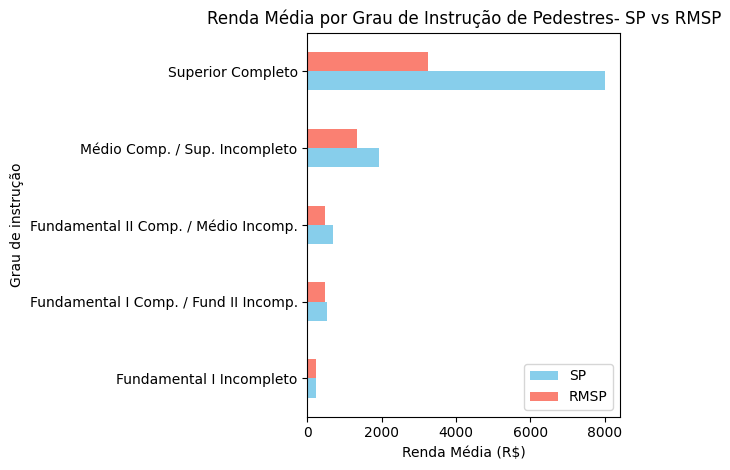

In [822]:
renda_grau_comparison.plot(kind='barh', title='Renda Média por Grau de Instrução de Pedestres- SP vs RMSP', xlabel='Renda Média (R$)', ylabel='Grau de instrução', color=['skyblue', 'salmon'])
plt.tight_layout()
plt.show()

### Análise Específica do Comportamento como Pedestre
**Motivações**
- Razões para caminhar (PE_BICI)
- Motivos de viagem (MOTIVO_D)

**Padrões de deslocamento**
- Distribuição de distâncias percorridas (DISTANCIA)
- Relação entre distância e motivo da viagem (MOTIVO_D)
- Relação entre distância e características demográficas

**Análise da Escolha pelo Meio A Pé (PE_BICI)**

In [823]:
sp_pe_bici_dist = (sp_pedestrians.groupby('PE_BICI_LABEL')['FE_VIA'].sum() / sp_pedestrians_weight * 100).round(2)
rmsp_pe_bici_dist = (rmsp_pedestrians.groupby('PE_BICI_LABEL')['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).round(2)

pe_bici_comparison = pd.DataFrame({
    'SP': sp_pe_bici_dist,
    'RMSP': rmsp_pe_bici_dist
})

pe_bici_comparison

,SP,RMSP
PE_BICI_LABEL,,
Atividade física,1.74,1.58
Condução cara,1.58,3.04
Condução demora para passar,0.52,0.90
Condução lotada,0.15,0.09
Medo de contágio,NaN,0.02
Outros motivos,0.59,1.05
Pequena distância,94.83,92.72
Ponto/Estação distante,0.49,0.43
Viagem demorada,0.10,0.17


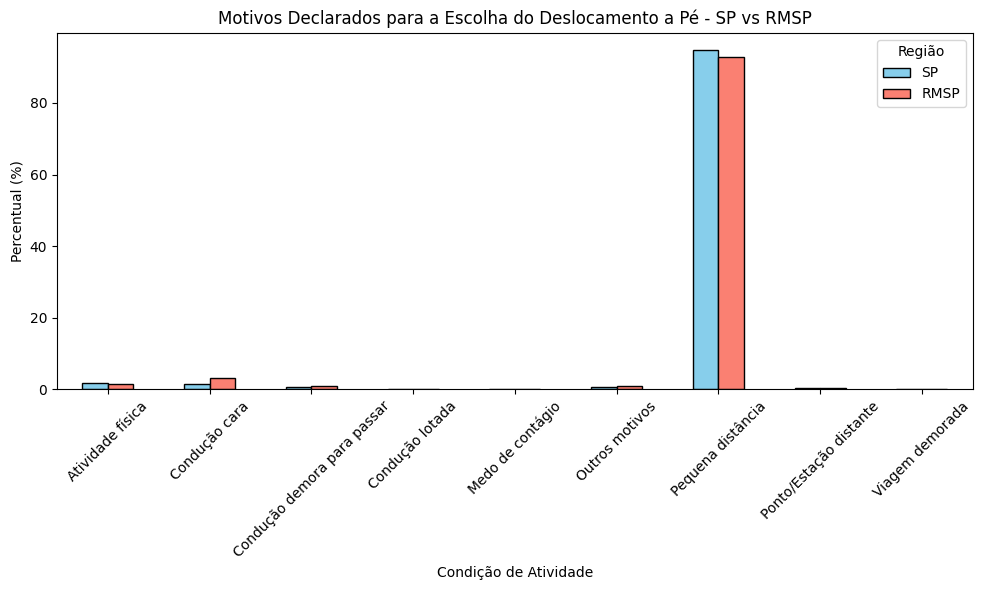

In [824]:
pe_bici_comparison.plot(kind='bar', figsize=(10, 6), edgecolor='black', color=['skyblue', 'salmon'])
plt.title('Motivos Declarados para a Escolha do Deslocamento a Pé - SP vs RMSP')
plt.xlabel('Condição de Atividade')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**Distribuição dos Motivos de deslocamento ao Destino (MOTIVO_D)**

In [825]:
sp_motivo_d_dist = (sp_pedestrians.groupby('MOTIVO_LABEL')['FE_VIA'].sum() / sp_pedestrians_weight * 100).round(2).sort_values(ascending=False)
sp_work_value = sp_motivo_d_dist[['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']].sum() 
sp_motivo_d_dist = sp_motivo_d_dist.drop(['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']) # remove setores de trabalho
sp_motivo_d_dist['Trabalho'] = sp_work_value # adiciona trabalho como setor unificado

rmsp_motivo_d_dist = (rmsp_pedestrians.groupby('MOTIVO_LABEL')['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).round(2).sort_values(ascending=False)
rmsp_work_value = rmsp_motivo_d_dist[['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']].sum() 
rmsp_motivo_d_dist = rmsp_motivo_d_dist.drop(['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']) # remove setores de trabalho
rmsp_motivo_d_dist['Trabalho'] = rmsp_work_value # adiciona trabalho como setor unificado

motivo_d_dist_comparison = pd.DataFrame({
    'SP': sp_motivo_d_dist,
    'RMSP': rmsp_motivo_d_dist
})

motivo_d_dist_comparison

,SP,RMSP
MOTIVO_LABEL,,
Assuntos Pessoais,1.16,1.47
Compras,1.94,2.07
Escola/Educação,29.55,31.31
Médico/Dentista/Saúde,1.02,0.94
Procurar Emprego,0.03,0.01
Recreação/Visitas/Lazer,1.62,1.13
Refeição,2.74,0.82
Residência,46.37,48.57
Trabalho,15.57,13.67


<Figure size 1800x1400 with 0 Axes>

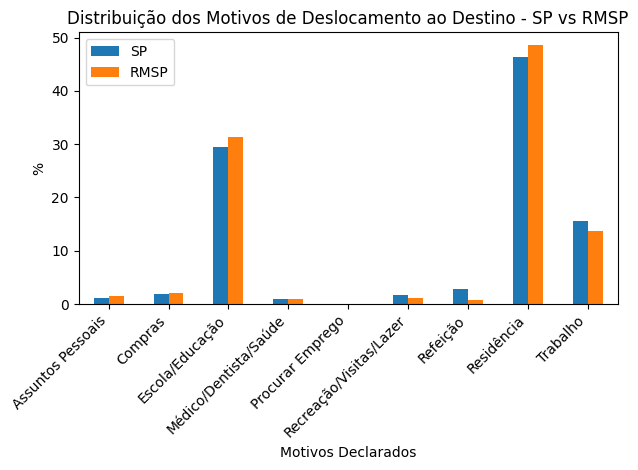

In [826]:
plt.figure(figsize=(18, 14))
motivo_d_dist_comparison.plot(
    kind='bar',
    title='Distribuição dos Motivos de Deslocamento ao Destino - SP vs RMSP',
    ylabel='%',
    xlabel="Motivos Declarados"
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Distribuição de distâncias percorridas (DISTANCIA)**

In [827]:
sp_distance_distribution = (sp_pedestrians.groupby('CAT_DISTANCIA', observed=False)['FE_VIA'].sum() / sp_pedestrians_weight * 100).round(2)
rmsp_distance_distribution = (rmsp_pedestrians.groupby('CAT_DISTANCIA', observed=False)['FE_VIA'].sum() / rmsp_pedestrians_weight * 100).round(2)

distance_dist_comparison = pd.DataFrame({
    'SP': sp_distance_distribution,
    'RMSP': rmsp_distance_distribution
})

distance_dist_comparison

,SP,RMSP
CAT_DISTANCIA,,
Muito curta (<500m),59.51,51.42
Curta (500-1000m),27.00,29.83
Média (1001-2000m),10.80,14.01
Longa (2001-5000m),2.16,3.91
Muito longa (>5000m),0.54,0.82


<Figure size 1000x600 with 0 Axes>

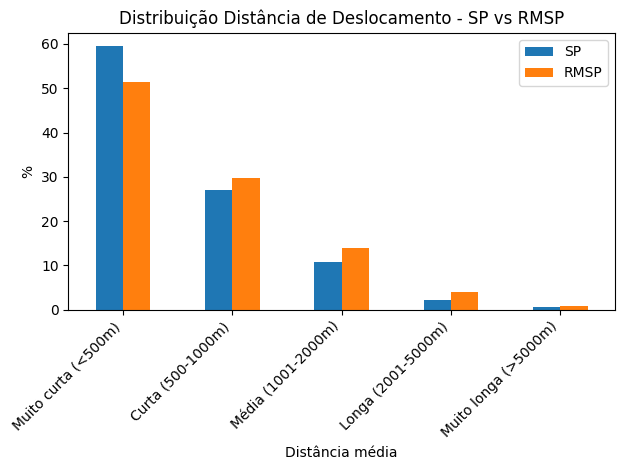

In [831]:
plt.figure(figsize=(10, 6))
distance_dist_comparison.plot(
    kind='bar',
    title='Distribuição Distância de Deslocamento - SP vs RMSP',
    ylabel='%',
    xlabel="Distância média"
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Relação entre distância e motivo da viagem**

In [829]:
sp_distancia_motivo = sp_pedestrians.groupby('MOTIVO_LABEL')['DISTANCIA'].mean().sort_values(ascending=False).round(2)
sp_work_value = sp_distancia_motivo[['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']].sum() 
sp_distancia_motivo = sp_distancia_motivo.drop(['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']) # remove setores de trabalho
sp_distancia_motivo['Trabalho'] = sp_work_value # adiciona trabalho como setor unificado

rmsp_distancia_motivo = rmsp_pedestrians.groupby('MOTIVO_LABEL')['DISTANCIA'].mean().sort_values(ascending=False).round(2)
rmsp_work_value = rmsp_distancia_motivo[['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']].sum() 
rmsp_distancia_motivo = rmsp_distancia_motivo.drop(['Trabalho Indústria', 'Trabalho Comércio', 'Trabalho Serviços']) # remove setores de trabalho
rmsp_distancia_motivo['Trabalho'] = rmsp_work_value # adiciona trabalho como setor unificado


distancia_motivo_dist_comparison = pd.DataFrame({
    'SP': sp_distancia_motivo,
    'RMSP': rmsp_distancia_motivo
})

distancia_motivo_dist_comparison

,SP,RMSP
MOTIVO_LABEL,,
Assuntos Pessoais,908.79,865.04
Compras,877.54,989.74
Escola/Educação,681.30,728.71
Médico/Dentista/Saúde,840.56,1233.10
Procurar Emprego,1545.86,707.79
Recreação/Visitas/Lazer,957.53,1040.32
Refeição,509.44,547.03
Residência,729.97,812.66
Trabalho,2036.67,2579.80


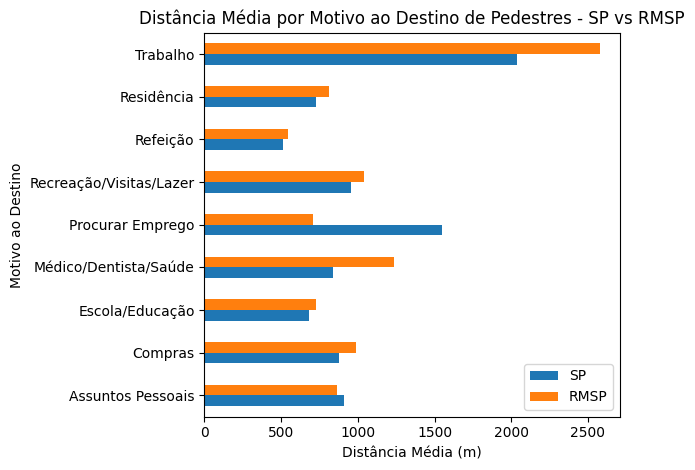

In [830]:
distancia_motivo_dist_comparison.plot(kind='barh', title='Distância Média por Motivo ao Destino de Pedestres - SP vs RMSP', xlabel='Distância Média (m)', ylabel="Motivo ao Destino")
plt.tight_layout()
plt.show()